In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv

def triangle_vertices(a):
    # Равносторонний треугольник с центром в (0,0)
    h = a * np.sqrt(3) / 2
    vertices = np.array([
        [-a/2, -h/3],
        [a/2, -h/3],
        [0, 2*h/3]
    ])
    return vertices
    
def rotate_points(points, angle_degrees):

    angle_rad = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    # Применяем матрицу поворота к каждой точке
    rotated_points = np.zeros_like(points)
    for i, point in enumerate(points):
        rotated_points[i] = rotation_matrix @ point
        
    return rotated_points

def is_inside_triangle(xp, yp, vertices, rotation_angle=0):
    # Проверка, лежит ли точка внутри треугольника (барицентрические координаты)

    if rotation_angle != 0:
        vertices = rotate_points(vertices, rotation_angle)
    
    V0, V1, V2 = vertices

    v0, v1, v2 = vertices
    d = (v1[1] - v2[1])*(v0[0] - v2[0]) + (v2[0] - v1[0])*(v0[1] - v2[1])
    a = ((v1[1] - v2[1])*(xp - v2[0]) + (v2[0] - v1[0])*(yp - v2[1])) / d
    b = ((v2[1] - v0[1])*(xp - v2[0]) + (v0[0] - v2[0])*(yp - v2[1])) / d
    c = 1 - a - b
    return (a >= 0) & (b >= 0) & (c >= 0)

def far_field_bessel_triangle(x, y, z, k, kappa, m, a, lambda_val, rotation_angle=0, N=100):
    # x, y — координаты на экране (можно массивы)
    # a — сторона треугольника
    # N — число точек по каждой оси для интегрирования по апертуре
    vertices = triangle_vertices(a)

    # Сетка по апертуре
    xpr = np.linspace(-a/2, a/2, N)
    ypr = np.linspace(-a/2, a/2, N)
    Xp, Yp = np.meshgrid(xpr, ypr)
    mask = is_inside_triangle(Xp, Yp, vertices, rotation_angle)
    Xp = Xp[mask]
    Yp = Yp[mask]

    # Полярные координаты
    Rp = np.sqrt(Xp**2 + Yp**2)
    Phip = np.arctan2(Yp, Xp)

    # Бесселев пучок в апертуре
    A = jv(m, kappa * Rp) * np.exp(1j * m * Phip)

    # Фазовый множитель
    phase = np.exp(-1j * k * (x * Xp + y * Yp) / z)

    # Интеграл по апертуре (суммируем по всем точкам внутри треугольника)
    dS = (a / N)**2  # площадь одного пикселя
    integral = np.sum(A * phase) * dS

    R = np.sqrt(z**2 + (x - Xp)**2 + (y - Yp)**2)
    k_z = np.sqrt(k**2 - kappa**2) if kappa != 0 else k
    factor = (1j*k - 1/R) * z/R + 1j*k_z
    exp_part = np.exp(1j * k * R)
    dS = (a / N)**2


    #factor = (1j*k - 1/Rp) * z/Rp + 1j*k_z
    # Общий множитель
    #U = (np.exp(1j * k * z) / (1j * z)) * integral
    integral = np.sum(A * exp_part * factor / (4 * np.pi * R) * dS)
    return integral


def plot_combined_intensity(x_range, y_range, intensity_list, m_values):
    """
    Отображение всех интенсивностей на одном графике
    """
    n_plots = len(m_values)

    if n_plots <= 3:
        fig, axes = plt.subplots(1, n_plots, figsize=(n_plots*5, 5))
    else:
        n_cols = int(np.ceil(np.sqrt(n_plots)))
        n_rows = int(np.ceil(n_plots / n_cols))
        
        # Создаем сетку графиков с одинаковым размером
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

    if n_plots == 1:
        axes = [axes]
    else:
        axes = np.array([axes])

    axes = axes.flatten()

    X, Y = np.meshgrid(x_range, y_range)

    for i, (intensity, m) in enumerate(zip(intensity_list, m_values)):
        if i < len(axes):
            ax = axes[i]
            im = ax.pcolormesh(X, Y, intensity.T, shading='auto', cmap='viridis')
            ax.set_title(f'm={m}')
            ax.set_xlabel('x/λ')
            ax.set_ylabel('y/λ')

    for i in range(len(intensity_list), len(axes)):
        axes[i].axis('off')

    plt.suptitle('Дифракция Бесселя для различных m', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()



In [3]:
def point_inside_triangle(x, y, vertices):
    """Проверка принадлежности точки треугольнику"""
    v1, v2, v3 = vertices
    cross1 = (v2[0]-v1[0])*(y-v1[1]) - (v2[1]-v1[1])*(x-v1[0])
    cross2 = (v3[0]-v2[0])*(y-v2[1]) - (v3[1]-v2[1])*(x-v2[0])
    cross3 = (v1[0]-v3[0])*(y-v3[1]) - (v1[1]-v3[1])*(x-v3[0])
    return (cross1 >= 0) == (cross2 >= 0) == (cross3 >= 0)

def angular_part(x, y, m):
    """Вычисляет угловую часть e^{imφ} в декартовых координатах"""
    rho = np.sqrt(x**2 + y**2)
    if m >= 0:
        return (x + 1j*y)**m / (rho**m if m != 0 else 1)
    else:
        return (x - 1j*y)**abs(m) / (rho**abs(m))

In [4]:
def compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples=100):
    """Вычисление дифракции Бесселя с оптимизацией памяти"""
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)
    x_ap, y_ap = np.meshgrid(np.linspace(x_min, x_max, N_samples),
                            np.linspace(y_min, y_max, N_samples))
    dx = (x_max - x_min) / (N_samples - 1)
    dy = (y_max - y_min) / (N_samples - 1)

    # Маска для точек внутри треугольника
    mask = np.vectorize(point_inside_triangle, excluded=['vertices'])(x_ap, y_ap, vertices=vertices)

    # Вычисления только для точек внутри
    x_p = x_ap[mask]
    y_p = y_ap[mask]

    # Векторизованные вычисления
    R = np.sqrt(z**2 + (X - x_p[:, None, None])**2 + (Y - y_p[:, None, None])**2)
    R = np.where(R < 1e-10, 1e-10, R)  # Избегаем деления на ноль

    kappa = np.sqrt(k**2 - k_z**2)
    angular_part_val = angular_part(x_p, y_p, m_target)
    bessel_part = jv(abs(m_target), kappa * np.sqrt(x_p**2 + y_p**2))
    exp_part = np.exp(1j * k * R)
    factor = (1j*k - 1/R) * z/R + 1j*k_z

    psi = np.sum(bessel_part[:, None, None] * angular_part_val[:, None, None] * exp_part * factor / (4 * np.pi * R) * dx * dy, axis=0)

    return np.abs(psi)**2

Plotting intensity for m = 0
Plotting intensity for m = 2


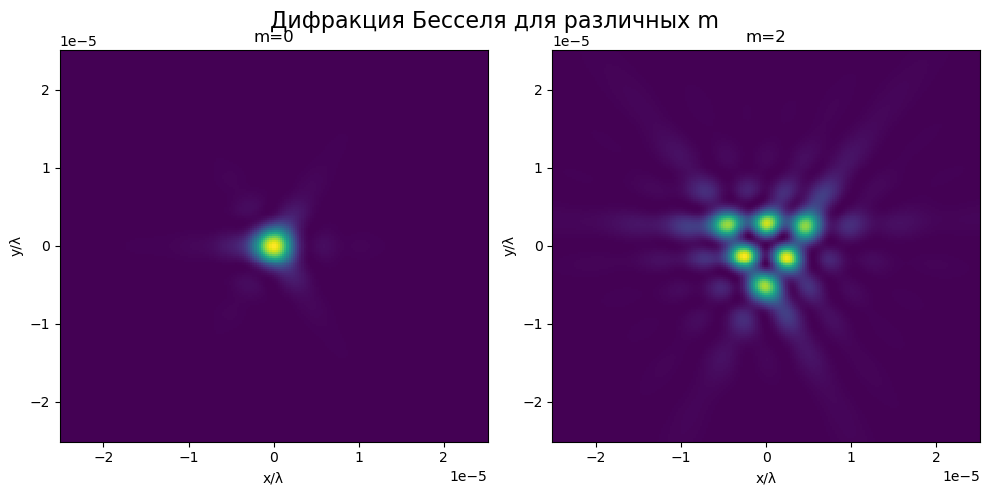

In [5]:
lambda_val = 0.5e-6  # длина волны, м
k_wave = 2 * np.pi / lambda_val

triangle_a_norm = 7  # сторона треугольника в длинах волн
triangle_a = triangle_a_norm * lambda_val  # в метрах

z_norm = 40.0  # расстояние до экрана в длинах волн
z = z_norm * lambda_val  # в метрах

rotation_angle = 0  # угол поворота треугольника (градусы)

kappa_bessel_factor = 0.00001
kappa_bessel = kappa_bessel_factor * k_wave

screen_extent_norm = 100.0  # диапазон по экрану в длинах волн
screen_extent = screen_extent_norm * lambda_val  # в метрах

num_points = 200  # число точек по x и y

# Сетка на экране (в метрах)
X = np.linspace(-screen_extent/2, screen_extent/2, num_points)
Y = np.linspace(-screen_extent/2, screen_extent/2, num_points)
XX, YY = np.meshgrid(X, Y)
intensity = np.zeros_like(XX, dtype=float)

m_values = [0,2]
'''
for m_val in m_values:
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            U = far_field_bessel_triangle(XX[i, j], YY[i, j], z, k_wave, kappa_bessel, m, triangle_a, N=40)
            intensity[i, j] = np.abs(U)**2

plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, intensity, shading='auto', cmap='viridis')
#plt.title(f'Fraunhofer diffraction: Bessel beam, triangle, m={m_values}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.colorbar(label='Intensity')
plt.show()
'''

intensity_list = []

for m in m_values:
    intensity = np.zeros_like(XX, dtype=float)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            U = far_field_bessel_triangle(XX[i, j], YY[i, j], z, k_wave, kappa_bessel, m, triangle_a, lambda_val, rotation_angle, N=40)
            intensity[i, j] = np.abs(U)**2

    print(f"Plotting intensity for m = {m}")
    #plot_intensity(X, Y, intensity, m=m)
    
    intensity_list.append(intensity)

    # Optionally plot phase:
    # print(f"Plotting phase for m = {m_val}")
    # plot_phase(x_range_norm, y_range_norm, phase_m, m=m_val)

plot_combined_intensity(X, Y, intensity_list, m_values)

Computing intensity for m = 0
Computing intensity for m = 2


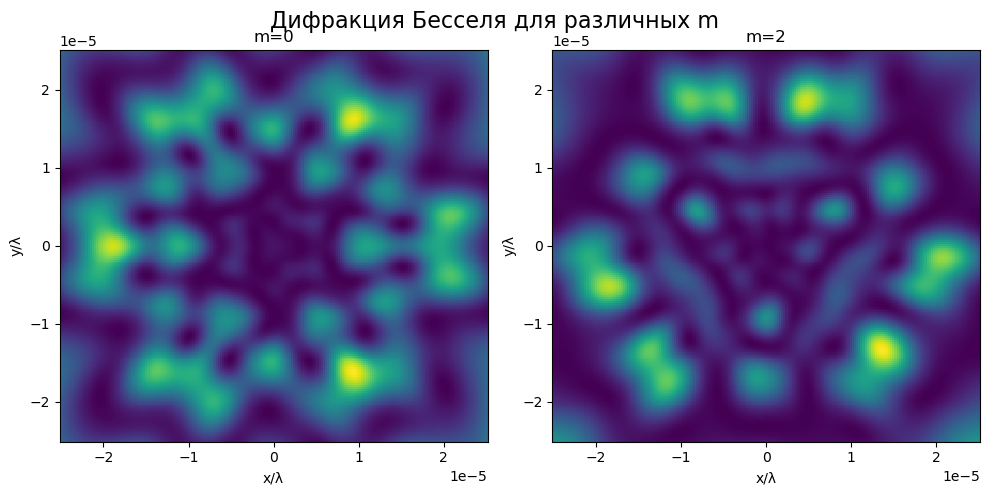

In [6]:

intensity_list = []

for m in m_values:
    print(f"Computing intensity for m = {m}")
    
    # Создаем вершины треугольника с учетом поворота
    vertices = triangle_vertices(triangle_a)
    if rotation_angle != 0:
        vertices = rotate_points(vertices, rotation_angle)
    
    # Используем функцию compute_bessel_diffraction
    intensity = compute_bessel_diffraction(
        vertices=vertices,
        X=XX, 
        Y=YY,
        z=z,
        k=k_wave,
        k_z=kappa_bessel,
        m_target=m,
        N_samples=100
    )
    
    intensity_list.append(intensity)

# Отображаем результаты
plot_combined_intensity(X, Y, intensity_list, m_values)

Computing intensity for m = 0


Computing intensity for m = 1
Computing intensity for m = 5
Computing intensity for m = -5
Computing intensity for m = 10


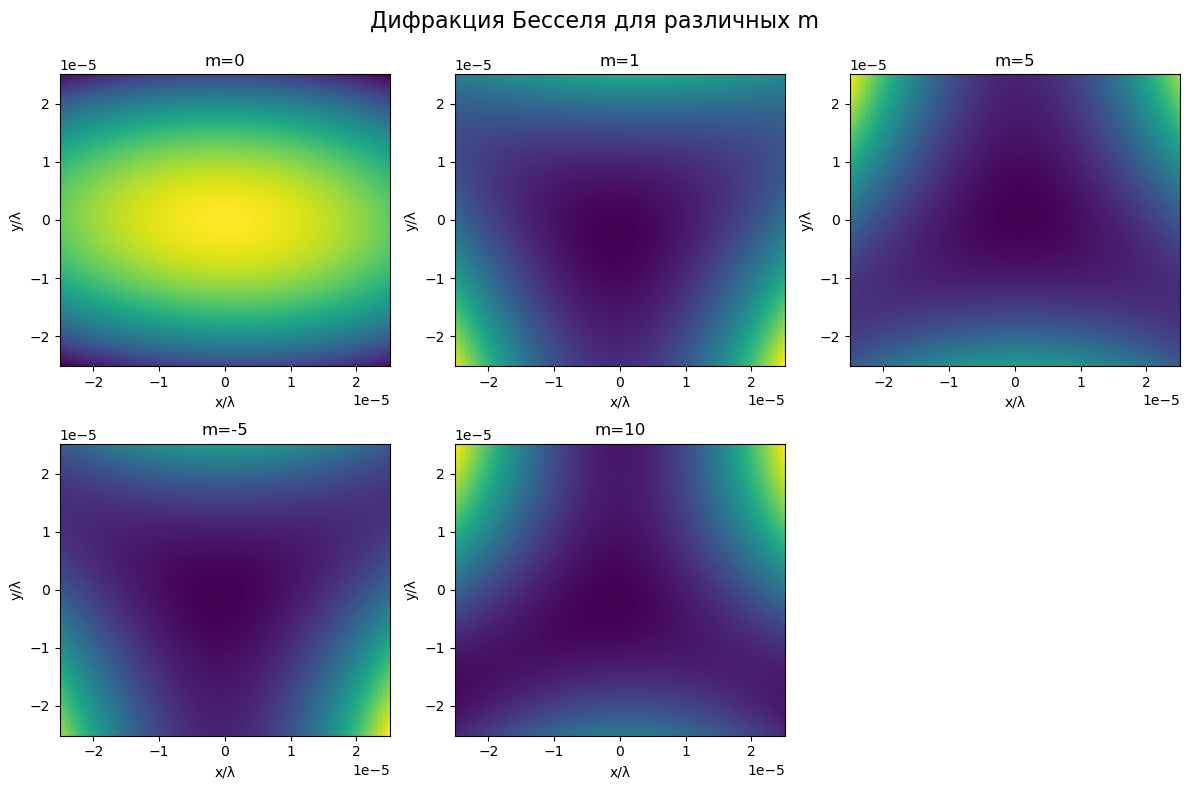

In [7]:
# Определяем параметры
lambda_val = 0.5e-6  # длина волны, м
k_wave = 2 * np.pi / lambda_val

triangle_a_norm = 7  # сторона треугольника в длинах волн
triangle_a = triangle_a_norm * lambda_val  # в метрах

z_norm = 1000.0  # расстояние до экрана в длинах волн
z = z_norm * lambda_val  # в метрах

rotation_angle = 0  # угол поворота треугольника (градусы)

kappa_bessel_factor = 0.3
kappa_bessel = kappa_bessel_factor * k_wave

screen_extent_norm = 100.0  # диапазон по экрану в длинах волн
screen_extent = screen_extent_norm * lambda_val  # в метрах

num_points = 200  # число точек по x и y

# Сетка на экране (в метрах)
X = np.linspace(-screen_extent/2, screen_extent/2, num_points)
Y = np.linspace(-screen_extent/2, screen_extent/2, num_points)
XX, YY = np.meshgrid(X, Y)

# Определяем значения топологического заряда
m_values = [0, 1, 5, -5, 10]

intensity_list = []

for m in m_values:
    print(f"Computing intensity for m = {m}")
    
    # Создаем вершины треугольника с учетом поворота
    vertices = triangle_vertices(triangle_a)
    if rotation_angle != 0:
        vertices = rotate_points(vertices, rotation_angle)
    
    # Используем функцию compute_bessel_diffraction
    intensity = compute_bessel_diffraction(
        vertices=vertices,
        X=XX, 
        Y=YY,
        z=z,
        k=k_wave,
        k_z=kappa_bessel,
        m_target=m,
        N_samples=100
    )
    
    intensity_list.append(intensity)

# Отображаем результаты
plot_combined_intensity(X, Y, intensity_list, m_values)

In [8]:
def general_bessel_triangle_diffraction(x_screen, y_screen, z_dist, k_wave, kappa_bessel, m_order, 
                                        triangle_a, rotation_angle=0, N_aperture_samples=100):
    """
    Расчет дифракции пучка Бесселя на треугольной апертуре с использованием
    более общей формулы дифракции (аналогично `compute_bessel_diffraction`).

    Аргументы:
    x_screen, y_screen: Координаты точки(ек) наблюдения на экране (скаляры или массивы NumPy).
    z_dist: Расстояние от апертуры до экрана (скаляр).
    k_wave: Волновое число (2*pi/lambda) (скаляр).
    kappa_bessel: Поперечная компонента волнового вектора пучка Бесселя (скаляр).
    m_order: Топологический заряд (порядок) пучка Бесселя (целое число).
    triangle_a: Длина стороны равностороннего треугольника апертуры (скаляр).
    rotation_angle: Угол поворота треугольника в градусах (скаляр, по умолчанию 0).
    N_aperture_samples: Количество точек выборки по каждой оси для интегрирования по апертуре 
                        (целое число, по умолчанию 100). N_aperture_samples > 0.

    Возвращает:
    U_complex: Комплексное поле в точке(ах) x_screen, y_screen (той же формы, что и x_screen).
    """

    # 1. Получение вершин треугольника
    #    Функция triangle_vertices должна быть определена во внешней области видимости.
    vertices = triangle_vertices(triangle_a)

    # 2. Создание сетки для интегрирования по апертуре
    #    Область интегрирования покрывает квадрат со стороной triangle_a, центрированный в нуле.
    if N_aperture_samples <= 0:
        # print("Предупреждение: N_aperture_samples должно быть положительным. Установлено в 1.")
        N_aperture_samples = 1
        
    xp_ap_range = np.linspace(-triangle_a / 2, triangle_a / 2, N_aperture_samples)
    yp_ap_range = np.linspace(-triangle_a / 2, triangle_a / 2, N_aperture_samples)
    Xp_ap_grid, Yp_ap_grid = np.meshgrid(xp_ap_range, yp_ap_range)

    # 3. Маска для точек внутри треугольника
    #    Ваша функция is_inside_triangle должна корректно обрабатывать rotation_angle.
    mask_inside = is_inside_triangle(Xp_ap_grid, Yp_ap_grid, vertices, rotation_angle)
    
    Xp_inside = Xp_ap_grid[mask_inside]
    Yp_inside = Yp_ap_grid[mask_inside]

    # Если на сетке нет точек внутри треугольника (например, N_aperture_samples слишком мало),
    # или если треугольник нулевого размера, то поле равно нулю.
    if Xp_inside.size == 0:
        # Преобразуем x_screen в массив, чтобы zeros_like работал корректно для скаляров
        _x_screen_obs_temp = np.asarray(x_screen)
        return np.zeros_like(_x_screen_obs_temp, dtype=complex)

    # 4. Расчет поля Бесселя в точках апертуры (внутри треугольника)
    Rp_aperture = np.sqrt(Xp_inside**2 + Yp_inside**2)
    Phip_aperture = np.arctan2(Yp_inside, Xp_inside) # arctan2(y,x)
    
    # Поле Бесселя в апертуре (на z_aperture = 0)
    A_aperture_field = jv(m_order, kappa_bessel * Rp_aperture) * np.exp(1j * m_order * Phip_aperture)

    # 5. Элемент площади для численного интегрирования
    if N_aperture_samples > 1:
        dx_ap = xp_ap_range[1] - xp_ap_range[0]
        dy_ap = yp_ap_range[1] - yp_ap_range[0]
        dS_aperture = dx_ap * dy_ap
    elif N_aperture_samples == 1:
        # Если только одна точка выборки, dS - это вся область сетки интегрирования.
        # Это грубое приближение. Для точности N_aperture_samples должно быть большим.
        dS_aperture = (triangle_a / N_aperture_samples)**2 
    # N_aperture_samples <=0 обработан выше, dS_aperture будет иметь смысл.


    # 6. Расчет продольной компоненты волнового вектора k_z
    #    k_z^2 = k_wave^2 - kappa_bessel^2
    #    k_z может быть действительным (распространяющийся пучок) или мнимым (эванесцентный).
    k_z_squared = k_wave**2 - kappa_bessel**2
    if k_z_squared < 0:
        k_z_propagation = 1j * np.sqrt(np.abs(k_z_squared)) # k_z чисто мнимое
    else:
        k_z_propagation = np.sqrt(k_z_squared) # k_z действительное

    # 7. Расчет интеграла дифракции
    _x_screen_obs = np.asarray(x_screen) # Преобразуем координаты экрана в массивы NumPy
    _y_screen_obs = np.asarray(y_screen)

    # Расширяем массивы координат апертуры и поля для векторизации
    # Новые оси добавляются в конец, чтобы соответствовать размерности _x_screen_obs, _y_screen_obs
    # Например, если Xp_inside (M,), а _x_screen_obs (Nx, Ny), то Xp_bc будет (M, 1, 1)
    Xp_bc = Xp_inside.reshape(Xp_inside.shape + (1,) * _x_screen_obs.ndim)
    Yp_bc = Yp_inside.reshape(Yp_inside.shape + (1,) * _x_screen_obs.ndim)
    A_aperture_field_bc = A_aperture_field.reshape(A_aperture_field.shape + (1,) * _x_screen_obs.ndim)

    # Расстояние R от каждой точки апертуры (Xp_bc, Yp_bc, 0) до каждой точки экрана (_x_screen_obs, _y_screen_obs, z_dist)
    # Форма R_dist будет (M, Nx, Ny) если _x_screen_obs (Nx,Ny)
    R_dist = np.sqrt(z_dist**2 + (_x_screen_obs - Xp_bc)**2 + (_y_screen_obs - Yp_bc)**2)
    R_dist = np.where(R_dist < 1e-12, 1e-12, R_dist) # Избегаем деления на ноль или слишком малых R

    # Экспоненциальный член exp(i*k*R)
    exp_propagator_term = np.exp(1j * k_wave * R_dist)
    
    # "Факторный" член, как в `compute_bessel_diffraction`
    factor_term_original = (1j * k_wave - 1.0/R_dist) * (z_dist / R_dist) + 1j * k_z_propagation
    
    # Собираем подынтегральное выражение, максимально приближенное к `compute_bessel_diffraction`:
    # A_aperture * exp_term * factor_term_original / (4 * np.pi * R_dist)
    integrand_all_terms = A_aperture_field_bc * exp_propagator_term * factor_term_original / (4 * np.pi * R_dist)
    
    # Суммируем вклады от всех точек апертуры (суммирование по первой оси, которая соответствует M точкам)
    # и умножаем на элемент площади dS_aperture
    U_complex = np.sum(integrand_all_terms, axis=0) * dS_aperture

    return U_complex

Characteristic aperture size D: 2.02e-06 m
Fraunhofer distance z_F: 8.17e-06 m
Calculating for zone: Near Zone (0.05z_F)
Calculating for zone: Near Zone (0.1z_F)
Calculating for zone: Transition Zone (0.3z_F)
Calculating for zone: Fraunhofer Boundary (z_F)
Calculating for zone: Far Zone (5z_F)
Calculating for zone: Far Zone (100z_F)


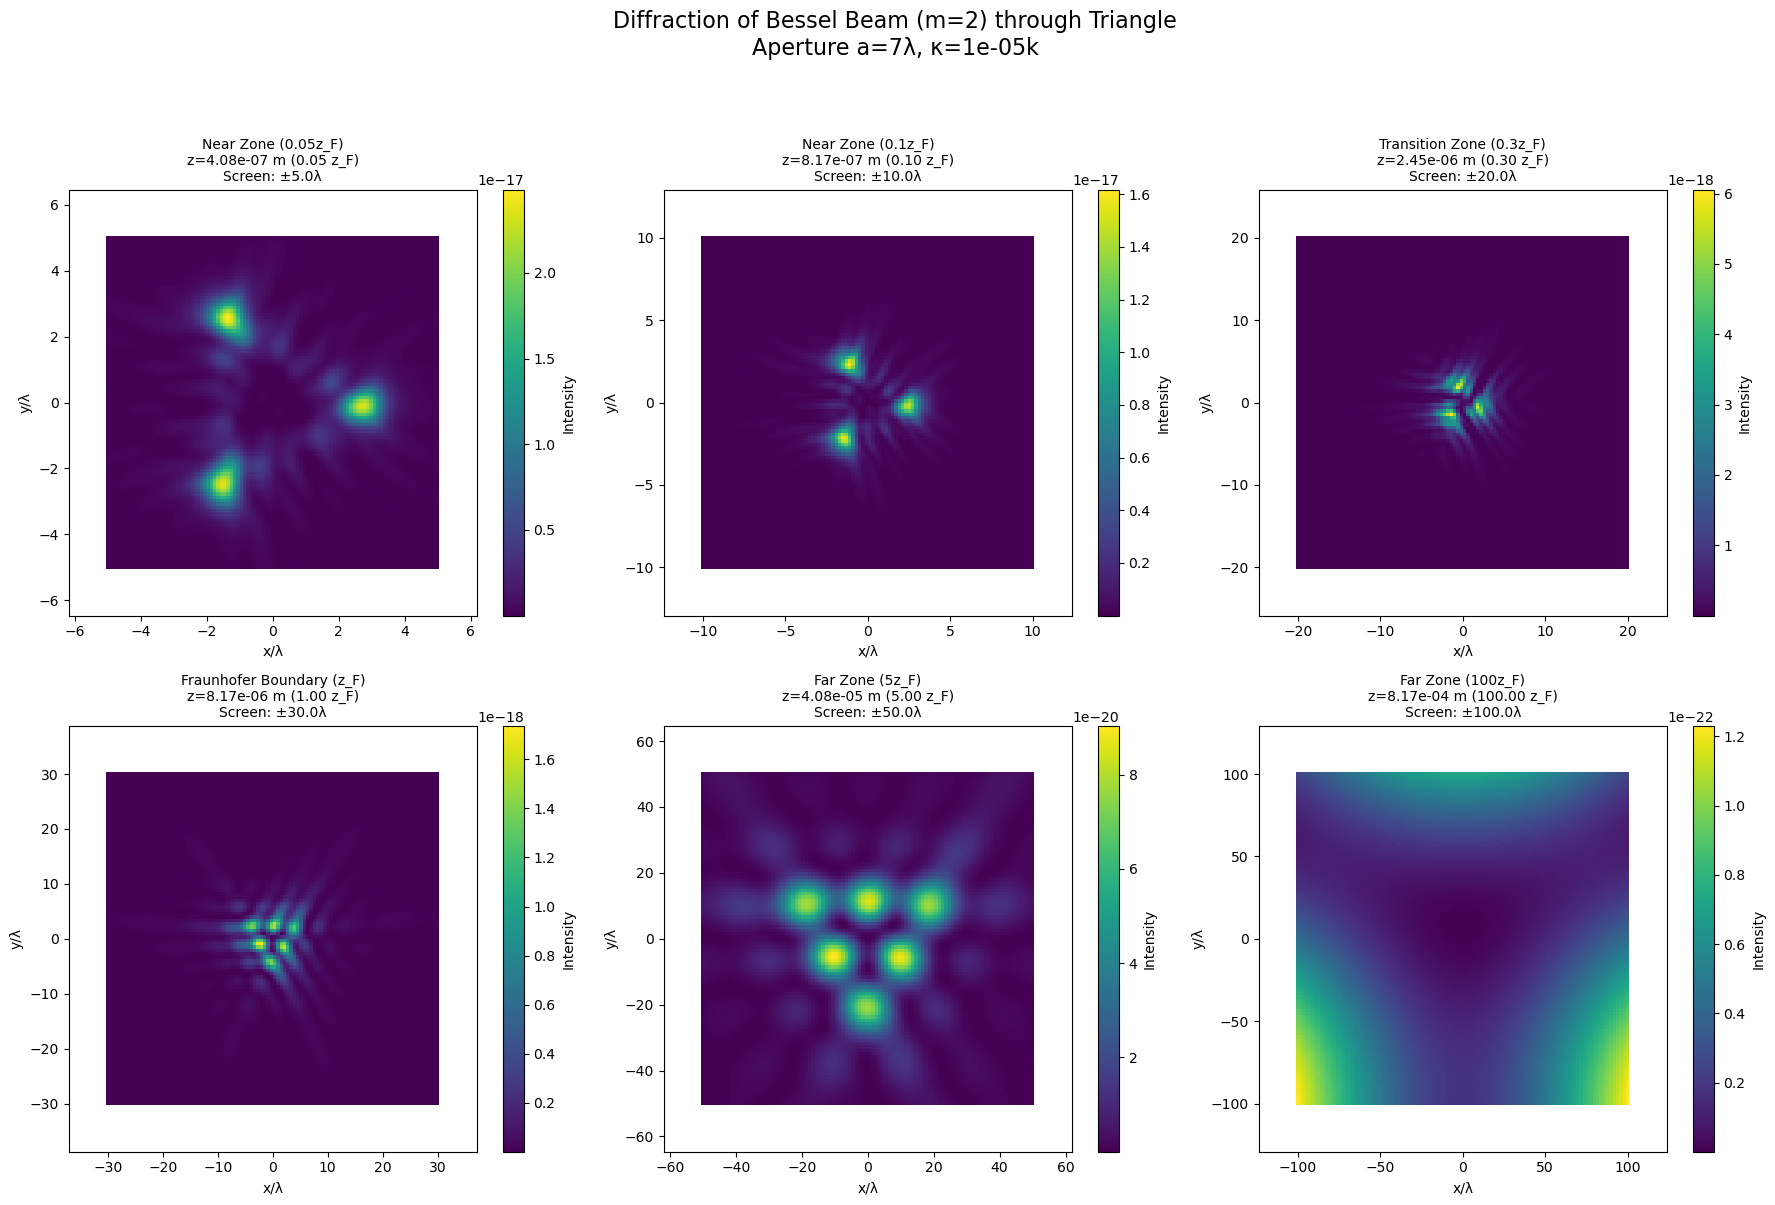

In [9]:
lambda_val = 0.5e-6  # длина волны, м
k_wave = 2 * np.pi / lambda_val

triangle_a_norm = 7  # сторона треугольника в длинах волн
triangle_a = triangle_a_norm * lambda_val  # в метрах

rotation_angle = 0  # угол поворота треугольника (градусы)

kappa_bessel_factor = 0.00001
kappa_bessel = kappa_bessel_factor * k_wave

# --- Parameters for Fresnel Zone Calculation ---
# Characteristic size of the aperture (distance from center to vertex for equilateral triangle)
D = triangle_a / np.sqrt(3) 

# Fraunhofer distance
z_fraunhofer = (D**2) / lambda_val
print(f"Characteristic aperture size D: {D:.2e} m")
print(f"Fraunhofer distance z_F: {z_fraunhofer:.2e} m")

# Definition of zones
# b_scale here is interpreted as screen half-width in units of lambda_val
zones = [
    {"z_factor": 0.05, "b_scale": 5.0,  "label": "Near Zone (0.05z_F)"}, # Adjusted b_scale for visibility
    {"z_factor": 0.1,  "b_scale": 10.0, "label": "Near Zone (0.1z_F)"},  # Adjusted b_scale
    {"z_factor": 0.3,  "b_scale": 20.0, "label": "Transition Zone (0.3z_F)"}, # Adjusted b_scale
    {"z_factor": 1.0,  "b_scale": 30.0, "label": "Fraunhofer Boundary (z_F)"}, # Adjusted b_scale
    {"z_factor": 5.0,  "b_scale": 50.0, "label": "Far Zone (5z_F)"},
    {"z_factor": 100.0,"b_scale": 100.0,"label": "Far Zone (100z_F)"}, # b_scale of 100 means screen from -100λ to 100λ
]

# Target m value for Bessel beam
m_target = 2 

# Number of points for screen grid and aperture integration
N_screen_points = 100  # Resolution of the calculated image on the screen
N_aperture_samples = 50 # Number of samples for integration over the aperture (N in far_field_bessel_triangle)

# --- Plotting Setup ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Adjusted to 2 rows, 3 columns for better aspect ratio
axes = axes.ravel() # Flatten the 2D array of axes

# --- Calculation and Plotting Loop ---
for idx, zone in enumerate(zones):
    print(f"Calculating for zone: {zone['label']}")
    
    # Distance to screen for the current zone
    z_dist = zone["z_factor"] * z_fraunhofer
    
    # Screen coordinates setup
    # zone["b_scale"] is the half-width of the screen in units of lambda_val
    screen_half_width_lambdas = zone["b_scale"] 
    
    # Screen coordinates in units of lambda for plotting
    x_coords_plot = np.linspace(-screen_half_width_lambdas, screen_half_width_lambdas, N_screen_points)
    y_coords_plot = np.linspace(-screen_half_width_lambdas, screen_half_width_lambdas, N_screen_points)
    
    # Screen coordinates in meters for calculation
    X_screen_m_coords = x_coords_plot * lambda_val
    Y_screen_m_coords = y_coords_plot * lambda_val
    
    XX_m, YY_m = np.meshgrid(X_screen_m_coords, Y_screen_m_coords)
    
    intensity = np.zeros_like(XX_m, dtype=float)
    
    # Calculate intensity on the screen
    for i in range(XX_m.shape[0]):
        for j in range(XX_m.shape[1]):
            U = far_field_bessel_triangle(
                XX_m[i, j], YY_m[i, j], 
                z_dist, 
                k_wave, kappa_bessel, m_target, 
                triangle_a, lambda_val, rotation_angle, N=N_aperture_samples
            )
            intensity[i, j] = np.abs(U)**2
            
    # Plotting for the current zone
    ax = axes[idx]
    # pcolormesh expects X, Y to define the grid cell boundaries, or centers if shading='gouraud'
    # If X,Y are 1D, Z should be (len(Y)-1, len(X)-1) or (len(Y), len(X))
    # Here, x_coords_plot and y_coords_plot are 1D arrays of coordinates.
    # intensity.T is used to match the orientation if XX_m, YY_m were 'xy' indexed.
    im = ax.pcolormesh(x_coords_plot, y_coords_plot, intensity.T, shading='auto', cmap='viridis')
    
    title_str = f"{zone['label']}\nz={z_dist:.2e} m ({zone['z_factor']:.2f} z_F)\nScreen: ±{screen_half_width_lambdas:.1f}λ"
    ax.set_title(title_str, fontsize=10)
    ax.set_xlabel("x/λ")
    ax.set_ylabel("y/λ")
    ax.axis('equal') # Ensure aspect ratio is preserved
    fig.colorbar(im, ax=ax, label='Intensity')

# Hide any unused subplots if the number of zones is less than subplot cells
for i in range(len(zones), len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Diffraction of Bessel Beam (m={m_target}) through Triangle\nAperture a={triangle_a_norm}λ, κ={kappa_bessel_factor}k', fontsize=16, y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()


Characteristic aperture size D: 2.02e-06 m
Fraunhofer distance z_F: 8.17e-06 m
Calculating for zone: Near Zone (0.05z_F)
Calculating for zone: Near Zone (0.1z_F)
Calculating for zone: Transition Zone (0.3z_F)
Calculating for zone: Fraunhofer Boundary (z_F)
Calculating for zone: Far Zone (5z_F)
Calculating for zone: Far Zone (100z_F)


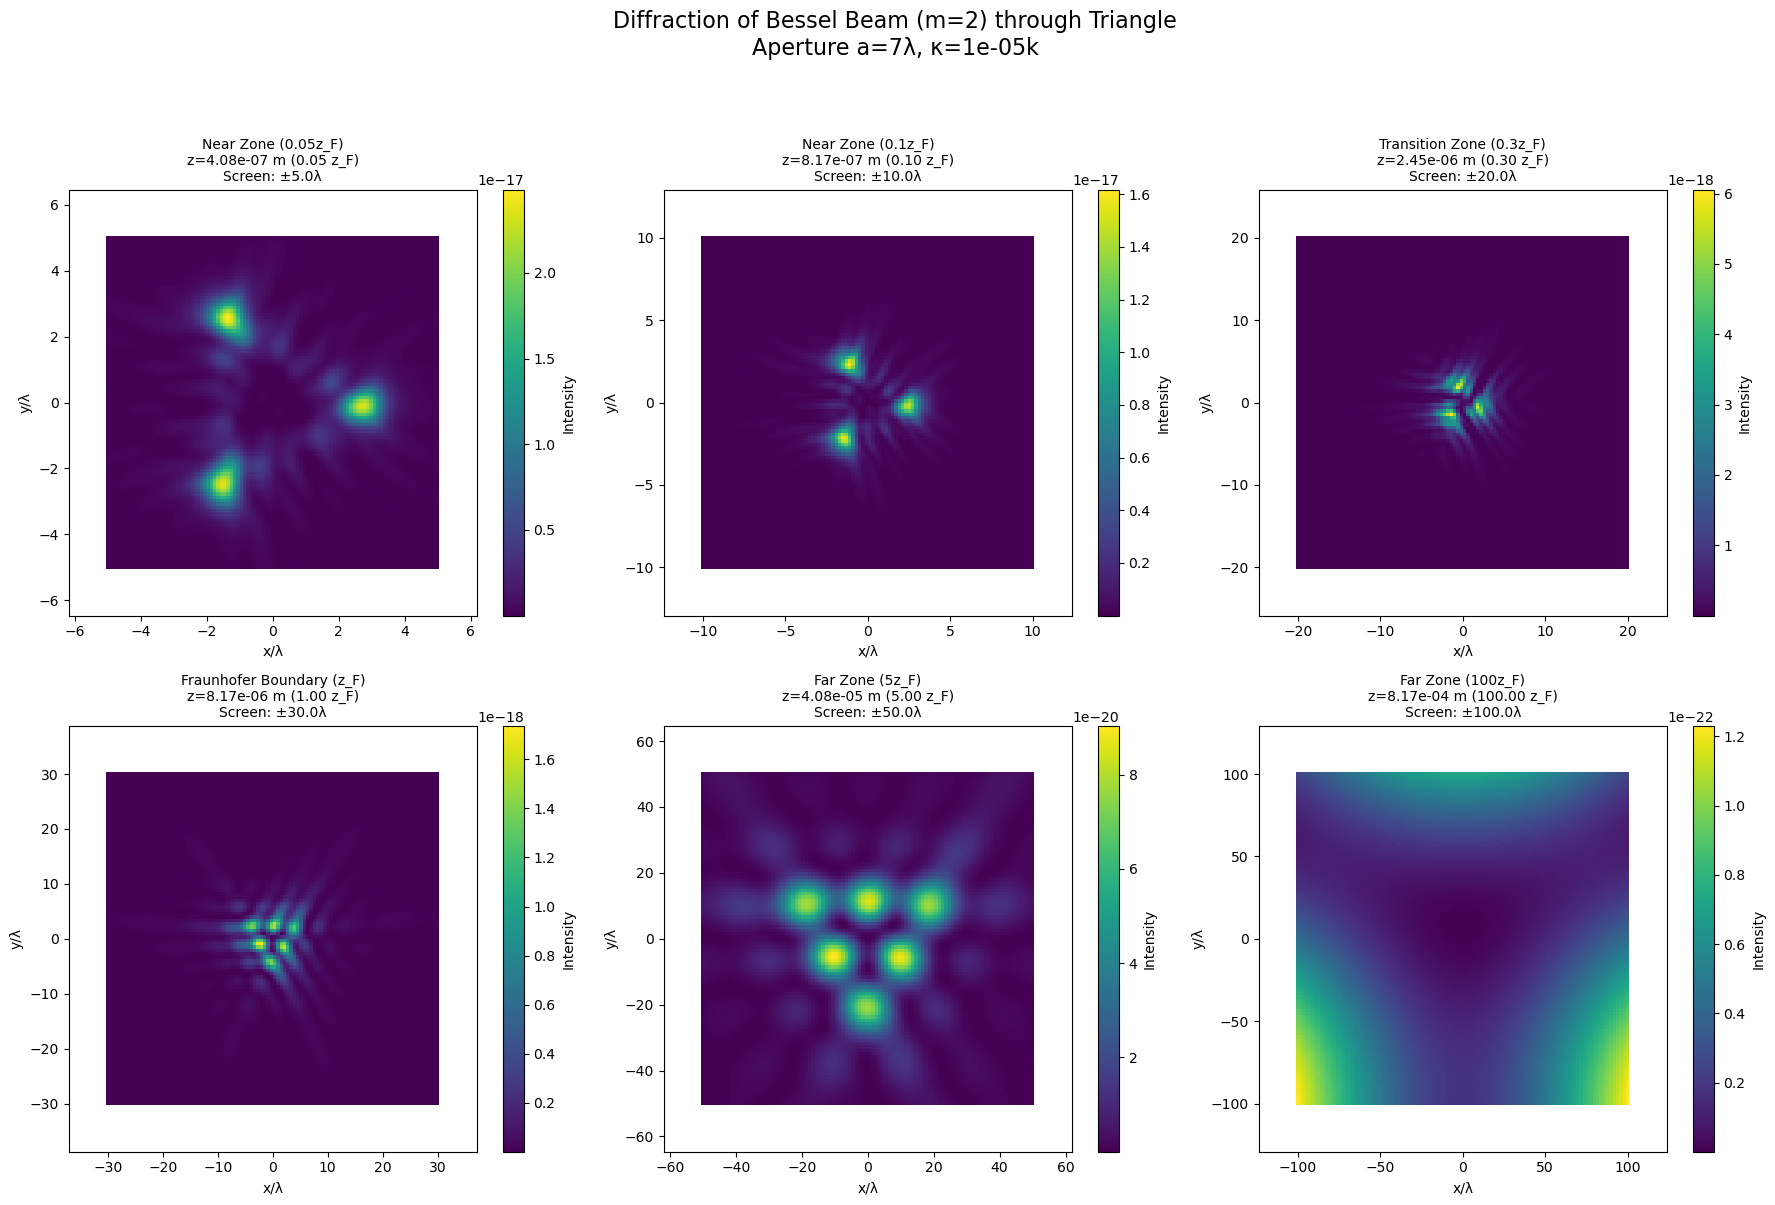

In [10]:
lambda_val = 0.5e-6  # длина волны, м
k_wave = 2 * np.pi / lambda_val

triangle_a_norm = 7  # сторона треугольника в длинах волн
triangle_a = triangle_a_norm * lambda_val  # в метрах

rotation_angle = 0  # угол поворота треугольника (градусы)

kappa_bessel_factor = 0.00001
kappa_bessel = kappa_bessel_factor * k_wave

# --- Parameters for Fresnel Zone Calculation ---
# Characteristic size of the aperture (distance from center to vertex for equilateral triangle)
D = triangle_a / np.sqrt(3) 

# Fraunhofer distance
z_fraunhofer = (D**2) / lambda_val
print(f"Characteristic aperture size D: {D:.2e} m")
print(f"Fraunhofer distance z_F: {z_fraunhofer:.2e} m")

# Definition of zones
# b_scale here is interpreted as screen half-width in units of lambda_val
zones = [
    {"z_factor": 0.05, "b_scale": 5.0,  "label": "Near Zone (0.05z_F)"}, # Adjusted b_scale for visibility
    {"z_factor": 0.1,  "b_scale": 10.0, "label": "Near Zone (0.1z_F)"},  # Adjusted b_scale
    {"z_factor": 0.3,  "b_scale": 20.0, "label": "Transition Zone (0.3z_F)"}, # Adjusted b_scale
    {"z_factor": 1.0,  "b_scale": 30.0, "label": "Fraunhofer Boundary (z_F)"}, # Adjusted b_scale
    {"z_factor": 5.0,  "b_scale": 50.0, "label": "Far Zone (5z_F)"},
    {"z_factor": 100.0,"b_scale": 100.0,"label": "Far Zone (100z_F)"}, # b_scale of 100 means screen from -100λ to 100λ
]

# Target m value for Bessel beam
m_target = 2 

# Number of points for screen grid and aperture integration
N_screen_points = 100  # Resolution of the calculated image on the screen
N_aperture_samples = 50 # Number of samples for integration over the aperture (N in far_field_bessel_triangle)

# --- Plotting Setup ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Adjusted to 2 rows, 3 columns for better aspect ratio
axes = axes.ravel() # Flatten the 2D array of axes

# --- Calculation and Plotting Loop ---
for idx, zone in enumerate(zones):
    print(f"Calculating for zone: {zone['label']}")
    
    # Distance to screen for the current zone
    z_dist = zone["z_factor"] * z_fraunhofer
    
    # Screen coordinates setup
    # zone["b_scale"] is the half-width of the screen in units of lambda_val
    screen_half_width_lambdas = zone["b_scale"] 
    
    # Screen coordinates in units of lambda for plotting
    x_coords_plot = np.linspace(-screen_half_width_lambdas, screen_half_width_lambdas, N_screen_points)
    y_coords_plot = np.linspace(-screen_half_width_lambdas, screen_half_width_lambdas, N_screen_points)
    
    # Screen coordinates in meters for calculation
    X_screen_m_coords = x_coords_plot * lambda_val
    Y_screen_m_coords = y_coords_plot * lambda_val
    
    XX_m, YY_m = np.meshgrid(X_screen_m_coords, Y_screen_m_coords)
    
    intensity = np.zeros_like(XX_m, dtype=float)
    
    # Calculate intensity on the screen
    for i in range(XX_m.shape[0]):
        for j in range(XX_m.shape[1]):
            U = far_field_bessel_triangle(
                XX_m[i, j], YY_m[i, j], 
                z_dist, 
                k_wave, kappa_bessel, m_target, 
                triangle_a, lambda_val, rotation_angle, N=N_aperture_samples
            )
            intensity[i, j] = np.abs(U)**2
            
    # Plotting for the current zone
    ax = axes[idx]
    # pcolormesh expects X, Y to define the grid cell boundaries, or centers if shading='gouraud'
    # If X,Y are 1D, Z should be (len(Y)-1, len(X)-1) or (len(Y), len(X))
    # Here, x_coords_plot and y_coords_plot are 1D arrays of coordinates.
    # intensity.T is used to match the orientation if XX_m, YY_m were 'xy' indexed.
    im = ax.pcolormesh(x_coords_plot, y_coords_plot, intensity.T, shading='auto', cmap='viridis')
    
    title_str = f"{zone['label']}\nz={z_dist:.2e} m ({zone['z_factor']:.2f} z_F)\nScreen: ±{screen_half_width_lambdas:.1f}λ"
    ax.set_title(title_str, fontsize=10)
    ax.set_xlabel("x/λ")
    ax.set_ylabel("y/λ")
    ax.axis('equal') # Ensure aspect ratio is preserved
    fig.colorbar(im, ax=ax, label='Intensity')

# Hide any unused subplots if the number of zones is less than subplot cells
for i in range(len(zones), len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Diffraction of Bessel Beam (m={m_target}) through Triangle\nAperture a={triangle_a_norm}λ, κ={kappa_bessel_factor}k', fontsize=16, y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()


Characteristic aperture size D: 2.02e-06 m
Fraunhofer distance z_F: 8.17e-06 m
Calculating for zone: Near Zone (0.05z_F)
Calculating for zone: Near Zone (0.1z_F)
Calculating for zone: Transition Zone (0.3z_F)
Calculating for zone: Fraunhofer Boundary (z_F)
Calculating for zone: Far Zone (5z_F)
Calculating for zone: Far Zone (100z_F)


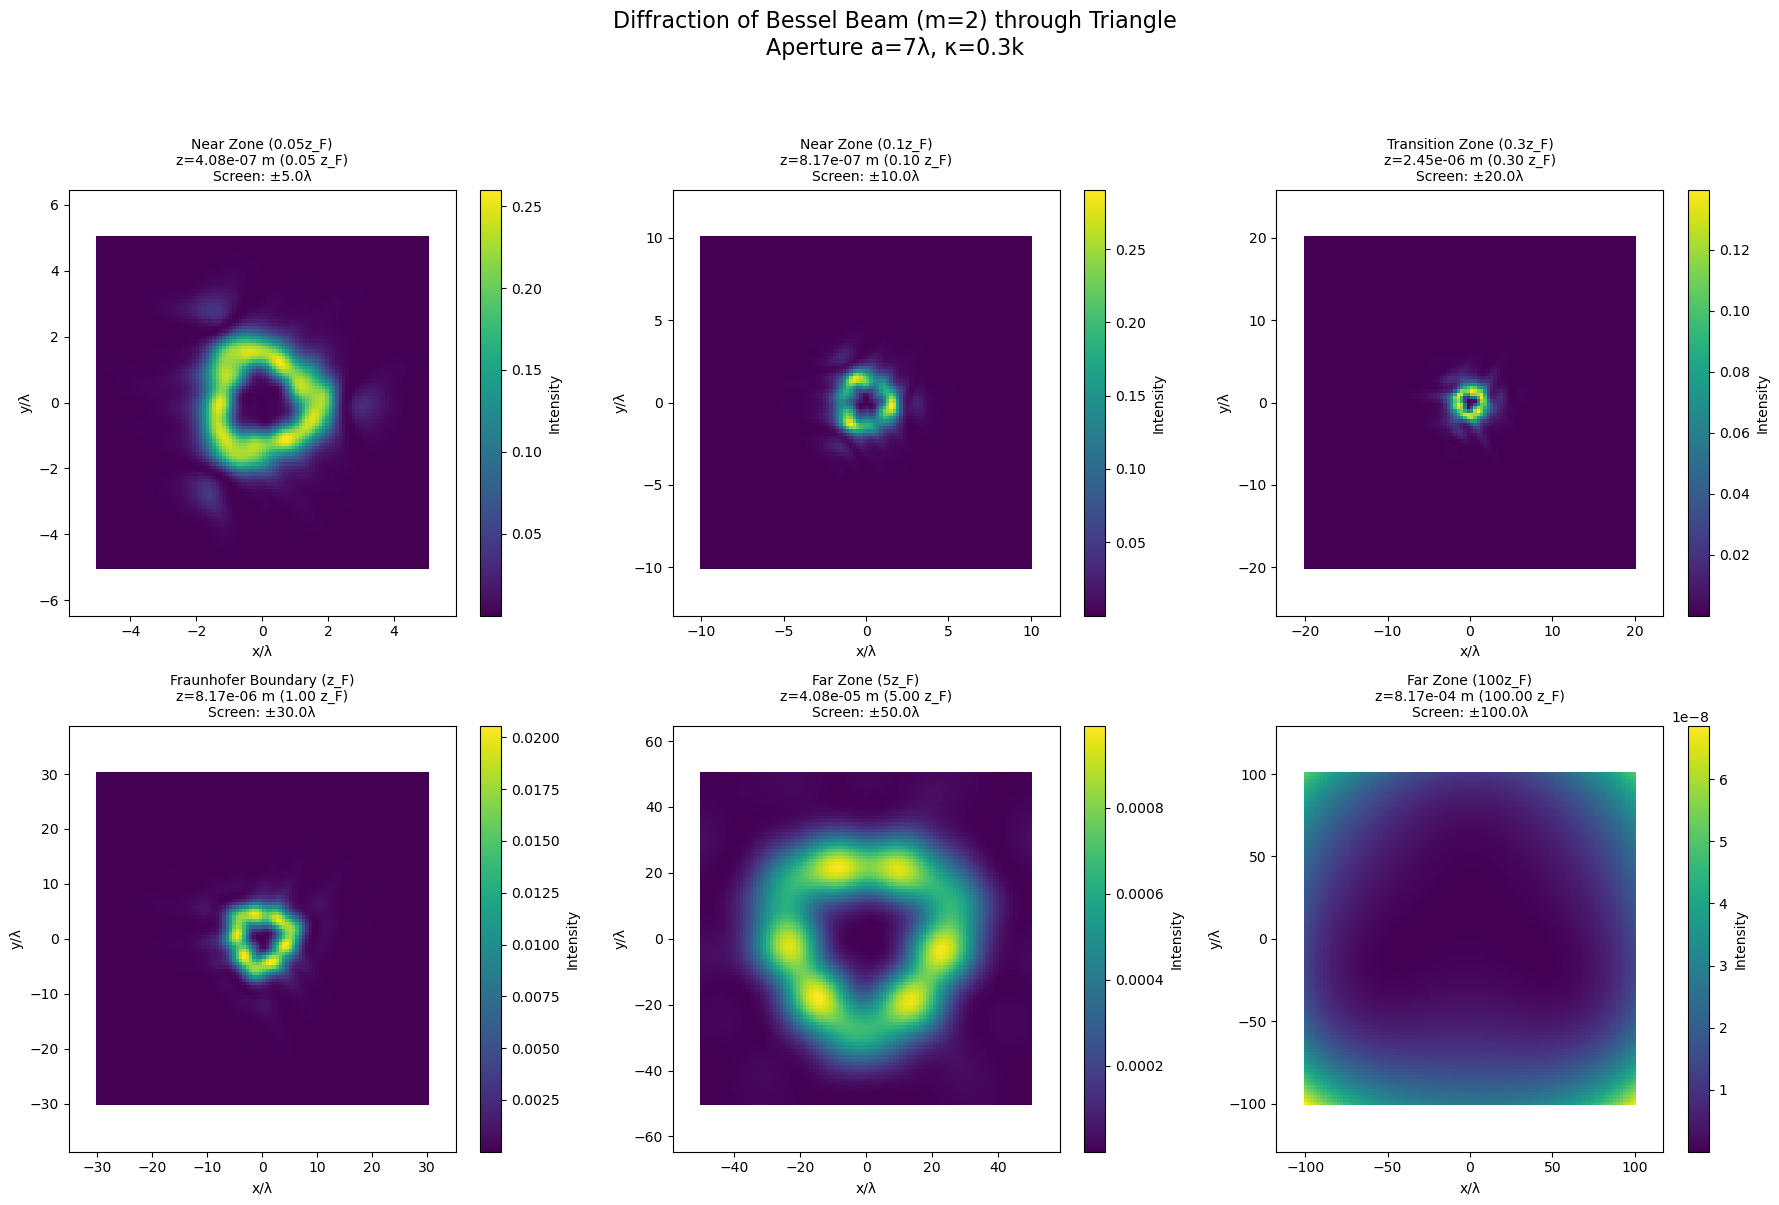

In [11]:
lambda_val = 0.5e-6  # длина волны, м
k_wave = 2 * np.pi / lambda_val

triangle_a_norm = 7  # сторона треугольника в длинах волн
triangle_a = triangle_a_norm * lambda_val  # в метрах

rotation_angle = 0  # угол поворота треугольника (градусы)

kappa_bessel_factor = 0.3
kappa_bessel = kappa_bessel_factor * k_wave

# --- Parameters for Fresnel Zone Calculation ---
# Characteristic size of the aperture (distance from center to vertex for equilateral triangle)
D = triangle_a / np.sqrt(3) 

# Fraunhofer distance
z_fraunhofer = (D**2) / lambda_val
print(f"Characteristic aperture size D: {D:.2e} m")
print(f"Fraunhofer distance z_F: {z_fraunhofer:.2e} m")

# Definition of zones
# b_scale here is interpreted as screen half-width in units of lambda_val
zones = [
    {"z_factor": 0.05, "b_scale": 5.0,  "label": "Near Zone (0.05z_F)"}, # Adjusted b_scale for visibility
    {"z_factor": 0.1,  "b_scale": 10.0, "label": "Near Zone (0.1z_F)"},  # Adjusted b_scale
    {"z_factor": 0.3,  "b_scale": 20.0, "label": "Transition Zone (0.3z_F)"}, # Adjusted b_scale
    {"z_factor": 1.0,  "b_scale": 30.0, "label": "Fraunhofer Boundary (z_F)"}, # Adjusted b_scale
    {"z_factor": 5.0,  "b_scale": 50.0, "label": "Far Zone (5z_F)"},
    {"z_factor": 100.0,"b_scale": 100.0,"label": "Far Zone (100z_F)"}, # b_scale of 100 means screen from -100λ to 100λ
]

# Target m value for Bessel beam
m_target = 2 

# Number of points for screen grid and aperture integration
N_screen_points = 100  # Resolution of the calculated image on the screen
N_aperture_samples = 50 # Number of samples for integration over the aperture (N in far_field_bessel_triangle)

# --- Plotting Setup ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Adjusted to 2 rows, 3 columns for better aspect ratio
axes = axes.ravel() # Flatten the 2D array of axes

# --- Calculation and Plotting Loop ---
for idx, zone in enumerate(zones):
    print(f"Calculating for zone: {zone['label']}")
    
    # Distance to screen for the current zone
    z_dist = zone["z_factor"] * z_fraunhofer
    
    # Screen coordinates setup
    # zone["b_scale"] is the half-width of the screen in units of lambda_val
    screen_half_width_lambdas = zone["b_scale"] 
    
    # Screen coordinates in units of lambda for plotting
    x_coords_plot = np.linspace(-screen_half_width_lambdas, screen_half_width_lambdas, N_screen_points)
    y_coords_plot = np.linspace(-screen_half_width_lambdas, screen_half_width_lambdas, N_screen_points)
    
    # Screen coordinates in meters for calculation
    X_screen_m_coords = x_coords_plot * lambda_val
    Y_screen_m_coords = y_coords_plot * lambda_val
    
    XX_m, YY_m = np.meshgrid(X_screen_m_coords, Y_screen_m_coords)
    
    intensity = np.zeros_like(XX_m, dtype=float)
    
    # Calculate intensity on the screen
    for i in range(XX_m.shape[0]):
        for j in range(XX_m.shape[1]):
            U = far_field_bessel_triangle(
                XX_m[i, j], YY_m[i, j], 
                z_dist, 
                k_wave, kappa_bessel, m_target, 
                triangle_a, lambda_val, rotation_angle, N=N_aperture_samples
            )
            intensity[i, j] = np.abs(U)**2
            
    # Plotting for the current zone
    ax = axes[idx]
    # pcolormesh expects X, Y to define the grid cell boundaries, or centers if shading='gouraud'
    # If X,Y are 1D, Z should be (len(Y)-1, len(X)-1) or (len(Y), len(X))
    # Here, x_coords_plot and y_coords_plot are 1D arrays of coordinates.
    # intensity.T is used to match the orientation if XX_m, YY_m were 'xy' indexed.
    im = ax.pcolormesh(x_coords_plot, y_coords_plot, intensity.T, shading='auto', cmap='viridis')
    
    title_str = f"{zone['label']}\nz={z_dist:.2e} m ({zone['z_factor']:.2f} z_F)\nScreen: ±{screen_half_width_lambdas:.1f}λ"
    ax.set_title(title_str, fontsize=10)
    ax.set_xlabel("x/λ")
    ax.set_ylabel("y/λ")
    ax.axis('equal') # Ensure aspect ratio is preserved
    fig.colorbar(im, ax=ax, label='Intensity')

# Hide any unused subplots if the number of zones is less than subplot cells
for i in range(len(zones), len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Diffraction of Bessel Beam (m={m_target}) through Triangle\nAperture a={triangle_a_norm}λ, κ={kappa_bessel_factor}k', fontsize=16, y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()


### Сравним параметры для far_field_bessel_triangle и compute_bessel_diffraction

In [12]:
# Параметры
lambda_val = 0.5e-6
k_wave = 2 * np.pi / lambda_val
triangle_a = 7 * lambda_val
rotation_angle = 0
kappa_bessel = 0 #0.3 * k_wave
m = 0
z = 100 * (triangle_a/np.sqrt(3))**2 / lambda_val  # Очень большая дальняя зона

# Координаты на экране (например, центр)
x0 = 0.0
y0 = 0.0

# Вычисления
U_far = far_field_bessel_triangle(x0, y0, z, k_wave, kappa_bessel, m, triangle_a, lambda_val, rotation_angle, N=300)
U_full = compute_bessel_diffraction(
    vertices=triangle_vertices(triangle_a),
    X=np.array([[x0]]), Y=np.array([[y0]]),
    z=z, k=k_wave, k_z=kappa_bessel, m_target=m, N_samples=300
)[0,0]

print("far_field_bessel_triangle:", np.abs(U_far)**2)
print("compute_bessel_diffraction:", U_full)
print("Ratio (modulus):", np.abs(U_full)/np.abs(U_far)**2)
#print("Phase difference:", np.angle(U_full) - np.angle(U_far))

far_field_bessel_triangle: 0.00016316908684529567
compute_bessel_diffraction: 1.1498874830871082e-11
Ratio (modulus): 7.047214060696085e-08


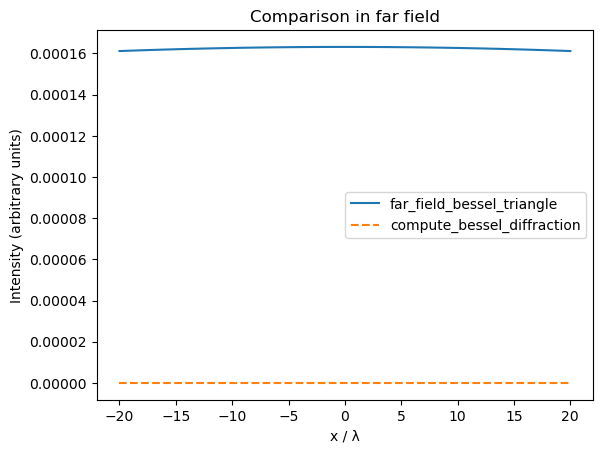

In [13]:
import matplotlib.pyplot as plt
x = np.linspace(-20*lambda_val, 20*lambda_val, 100)
y = np.zeros_like(x)

U_far = np.array([far_field_bessel_triangle(xi, 0, z, k_wave, kappa_bessel, m, triangle_a, lambda_val, rotation_angle, N=300) for xi in x])
U_full = np.array([compute_bessel_diffraction(
    vertices=triangle_vertices(triangle_a),
    X=np.array([[xi]]), Y=np.array([[0]]),
    z=z, k=k_wave, k_z=kappa_bessel, m_target=m, N_samples=300
)[0,0] for xi in x])

plt.plot(x/lambda_val, np.abs(U_far)**2, label='far_field_bessel_triangle')
plt.plot(x/lambda_val, np.abs(U_full), '--', label='compute_bessel_diffraction')
plt.xlabel('x / λ')
plt.ylabel('Intensity (arbitrary units)')
plt.legend()
plt.title('Comparison in far field')
plt.show()